We need to see what is going on with the differential peak files.

In [5]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dataDirectory = '/home/h1bennet/strains/data/ATAC/'
workingDirectory = '/home/h1bennet/strains/results/00_Strains_Control_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# Read in differential ATAC-seq data

In [7]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_idr_peaks_merged.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (64770, 26)
getDiffExpression selected transcripts (63491, 35)
annotatePeaks selected peaks (63491, 26)


In [39]:
if not os.path.isdir('./heatmap_peaks/'):
    os.mkdir('./heatmap_peaks/')

In [9]:
comp_dict.keys()

dict_keys(['00_c57 vs. 01_balbc', '00_c57 vs. 02_aj', '01_balbc vs. 02_aj'])

Pull out significant peaks

In [14]:
comp_dict.keys()

dict_keys(['00_c57 vs. 01_balbc', '00_c57 vs. 02_aj', '01_balbc vs. 02_aj'])

In [43]:
de.columns

Index(['Chr', 'Start', 'End', 'Annotation', 'gene', 'TSS_dist', 'log2fc',
       'pval', 'adj_pval', 'location'],
      dtype='object')

In [51]:
pval = 0.05
fc = 1

# grab differential enhancers for each comparison
for comp in comp_dict.keys():
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)) & np.abs(de.TSS_dist >= 3000))
    de_filt = de.loc[sig_peaks_bool, :]
    de_filt = de_filt.sort_values('log2fc', ascending=False)
    sig_peaks_id = (de_filt.loc[sig_peaks_bool, :].index.tolist())
    
    peaks.loc[sig_peaks_id, :].sort_values('Peak Score', ascending=False).iloc[:, :5].to_csv(
        './heatmap_peaks/'+comp.replace(' vs. ', '_vs_')+'_sig_peaks.txt',
        sep='\t')

# Annotate peaks with merged peak files.

In [52]:
if not os.path.isdir('./annotated_peaks/'):
    os.mkdir('./annotated_peaks/')

    annotatePeaks.pl ./differential_peaks/00_c57_vs_01_balbc_sig_peaks.txt mm10 \
    -size 6000 -hist 50 -ghist -d \
    ./merged_tagdirs/balbc_Kupffer_ATAC_young_control/ \
    ./merged_tagdirs/c57_Kupffer_ATAC_young_control/ \
    ../00_Strains_Control_H3K27Ac/merged_tagdirs/balbc_Kupffer_h3k27ac_young_control/ \
    ../00_Strains_Control_H3K27Ac/merged_tagdirs/c57_Kupffer_h3k27ac_young_control/ \
    > ./annotated_peaks/00_c57_vs_01_balbc_sig_peaks_atac_h3k27ac.txt


## Try making clustermap

In [53]:
df = pd.read_csv('./annotated_peaks/00_c57_vs_01_balbc_sig_peaks_atac_h3k27ac.txt',
                 sep='\t',
                 index_col=0)

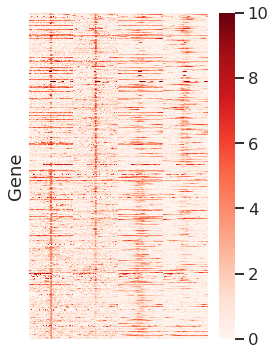

In [55]:
fig, ax = plt.subplots(figsize=(4,6))
sns.heatmap(np.log2(df+1),
            cmap='Reds',
            vmax=10,
            xticklabels=0,
            yticklabels=0,
            ax=ax)

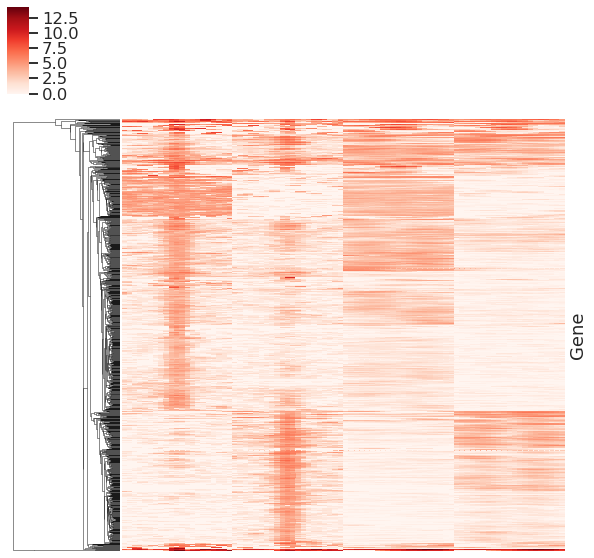

In [37]:
sns.clustermap(np.log2(df+1),
               cmap='Reds',
               # z_score=1,
               col_cluster=False,
               xticklabels=0,
               yticklabels=0)

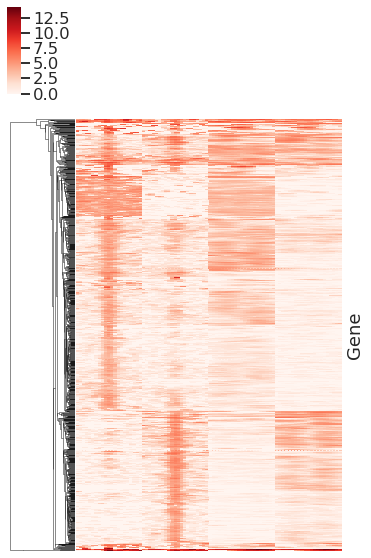

In [23]:
sns.clustermap(np.log2(df+1),
               cmap='Reds',
               # z_score=0,
               vmin=0,
               #vmax=12,
               col_cluster=False,
               row_cluster=True,
               #method='weighted',
               xticklabels=0,
               yticklabels=0,
               figsize=(6,10))

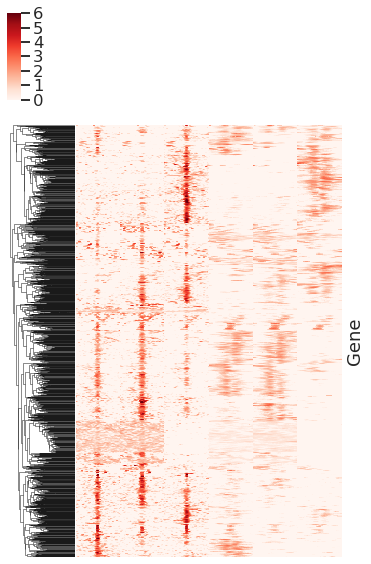

In [44]:
sns.clustermap(np.log2(df+1),
               cmap='Reds',
               z_score=0,
               vmin=0,
               vmax=6,
               col_cluster=False,
               row_cluster=True,
               method='weighted',
               xticklabels=0,
               yticklabels=0,
               figsize=(6,10))

Need to figure out a way to eliminate some of these junky peaks in the middle...

Check whether i messed up making the merged tag directories...

    annotatePeaks.pl ./differential_peaks/all_pairwise_distal_sig_peaks.txt mm10 \
    -size 2000 -hist 50 -ghist -d \
    ./merged_tagdirs/aj_Kupffer_ATAC_young_control/ \
    ./merged_tagdirs/balbc_Kupffer_ATAC_young_control/ \
    ./merged_tagdirs/c57_Kupffer_ATAC_young_control/ \
    ./merged_tagdirs/00_C57_Kupffer_ATAC_young_control/ \
    ./merged_tagdirs/01_balbc_Kupffer_ATAC_young_control/ \
    ./merged_tagdirs/02_aj_Kupffer_ATAC_young_control/ \
    > ./annotated_peaks/all_pairwise_distal_sig_peaks_ghist_atac_test.txt

In [49]:
df = pd.read_csv('./annotated_peaks/all_pairwise_distal_sig_peaks_ghist_atac_test.txt',
                 sep='\t',
                 index_col=0)

# Try using a merged peaks first approach

    mergePeaks ./atac_peak_files/balbcj_kupffer_control_young.idr \
    ./atac_peak_files/c57bl6j_kupffer_control_young.idr \
    > ./heatmap_peaks/balb_c57_merged_peaks.txt
    
    mergePeaks ./poised_enhancers/BALBcJ_poised_enhancer_peaks.txt \
    ./poised_enhancers/C57Bl6J_poised_enhancer_peaks.txt \
    > ./heatmap_peaks/balb_c57_merged_poised_peaks.txt

    annotatePeaks.pl ./heatmap_peaks/balb_c57_merged_peaks.txt mm10 \
    -size 6000 -hist 50 -ghist -d \
    ./merged_tagdirs/balbc_Kupffer_ATAC_young_control/ \
    ./merged_tagdirs/c57_Kupffer_ATAC_young_control/ \
    ../00_Strains_Control_H3K27Ac/merged_tagdirs/balbc_Kupffer_h3k27ac_young_control/ \
    ../00_Strains_Control_H3K27Ac/merged_tagdirs/c57_Kupffer_h3k27ac_young_control/ \
    > ./heatmap_peaks/balb_c57_merged_peaks_ghist.txt

In [57]:
df = pd.read_csv('/home/h1bennet/strains/data/annotations_files/mm10_exons_snps.txt',
                 sep='\t')

In [61]:
df.head()

,RepeatID (cmd=analyzeRepeats.pl rna mm10 -count exons),chr,start,end,strand,Code,Divergence,FullStart,FullEnd,BALBCJ - 1
0,NM_008946--Part7,chr11,70527437,70527579,+,E:70527437,0,70525357,70527858,NaN
1,NM_001302559--Part8,chr11,83188663,83189294,+,E:83188663,0,83175186,83190216,NaN
2,NM_001252494--Part16,chr11,54639750,54639858,+,E:54639750,0,54522845,54699286,NaN
3,NM_001348207--Part11,chr11,79029029,79029083,-,E:79029029,0,79013440,79059836,NaN
4,NR_045038--Part7,chr11,80391331,80391401,+,E:80391331,0,80383279,80405873,NaN


In [62]:
df['gene'] = df.iloc[:, 0].str.split('--').str[0]

In [65]:
len(df.gene.unique())

36037

In [60]:
df['BALBCJ - 1'].isna().value_counts()

True     241439
False     26773
Name: BALBCJ - 1, dtype: int64